# Multi Task models using Keras and Tensor Flow

## Project Goal

Import MNIST data set and then add random background and a predominant color to each number(R,G,B).

Each image now has 2 features a digit(0-9) and a color (R,G,B) and we want to construct a CNN using tensorflow keras to do a multi classification on digits as well as color.

In [2]:
# import libraries and packages

import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf

try:
    shutil.rmtree('logs')
except:
    pass

Use the MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 2s 0us/step


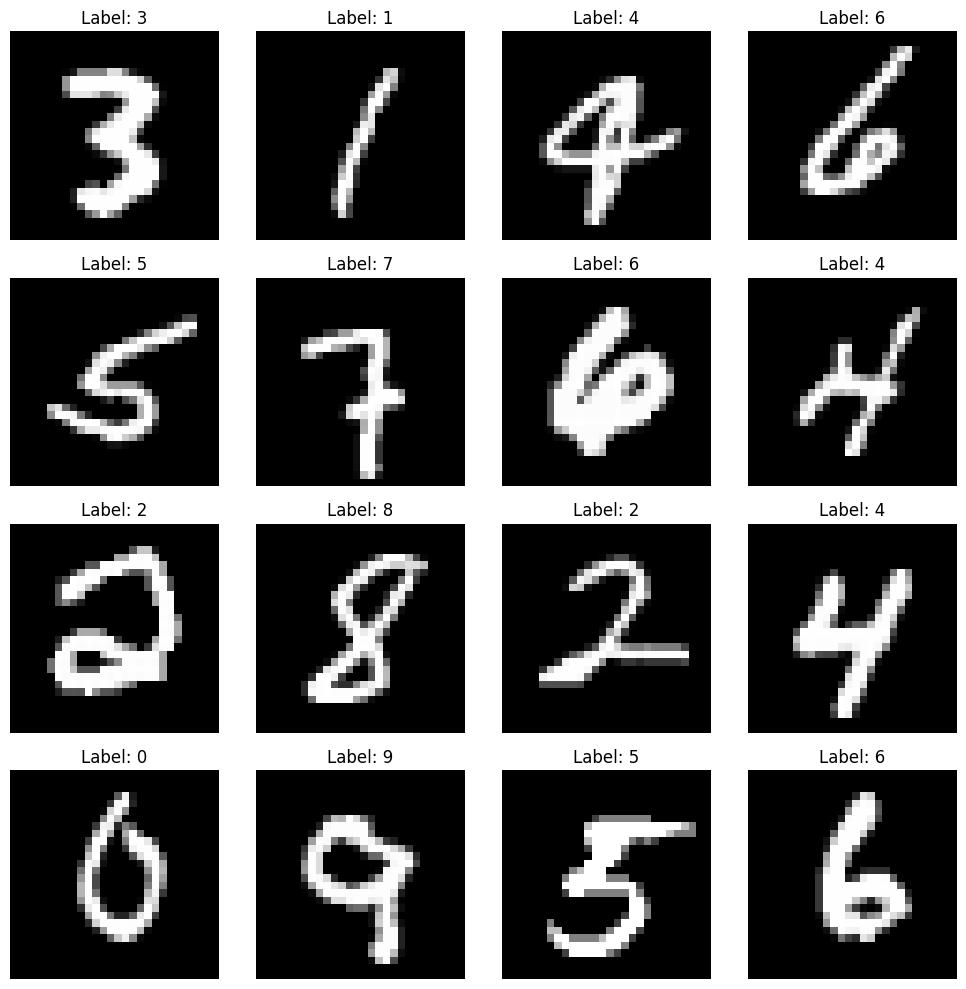

In [4]:
# Plot the images
grid_size = (4, 4)
num_images = grid_size[0] * grid_size[1]

# Generate random indices to select images from the training set
random_indices = np.random.choice(len(x_train), size=num_images, replace=False)

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))

# Iterate over the axes and plot random images with their corresponding labels
for i, ax in enumerate(axes.flat):
    # Get the index of the random image
    idx = random_indices[i]
    # Plot the image
    ax.imshow(x_train[idx], cmap = 'gray')
    # Set the title as the corresponding label
    ax.set_title(f"Label: {y_train[idx]}")
    # Turn off axis
    ax.axis('off')
plt.savefig('./mnist_set.pdf')
# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

## Generate random noise

Using the MNIST data set of numbers on a clear black background we add a random colour to the number (R,G,B) and in addition we add noise to the background to make the image unclear

In [5]:
def random_gen(x,y):
    col = np.random.randint(0,3) # generate a random integer for red,green, blue
    # add a random background to the image
    image = 0.5 * np.random.rand(28,28,3)
    image[:,:,col] += 0.5*x # add the mnist number to random backgorund
    return image,y, col

In [6]:
col_dict = {0:'red',1:'green',2:'blue'}

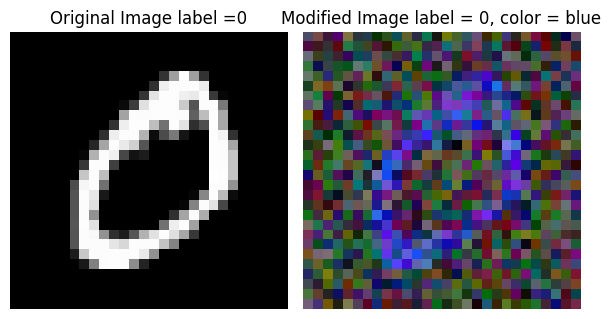

In [7]:
x,y,c = random_gen(x_train[1], y_train[1])

# Create a figure with two subplots arranged vertically
fig, axes = plt.subplots(1, 2, figsize=(6, 10))

# Plot the image in the first subplot
axes[0].imshow(x_train[1], cmap='gray')
axes[0].set_title(f'Original Image label ={y_train[1]}')
axes[0].axis('off')

# Plot the image in the second subplot
axes[1].imshow(x)
axes[1].set_title(f'Modified Image label = {y}, color = {col_dict[c]}')
axes[1].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('./mod_image.pdf')
# Show the plot
plt.show()

## Generate the Data set
 Apply the random_gen() function to the MNIST data set


In [8]:
def generate_data(x, y, batch_size=32):
    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size,))  # 0-9
        col_batch = np.zeros((batch_size,))  # 0-2

        for i in range(batch_size):
            idx = np.random.randint(0, len(y))
            image, digit, color = random_gen(x[idx], y[idx])
            x_batch[i] = image
            y_batch[i] = digit
            col_batch[i] = color

        yield x_batch, [y_batch, col_batch]


In [9]:
 x, [y, c] = next(generate_data(x_train, y_train, 1))

[6.] [1.]


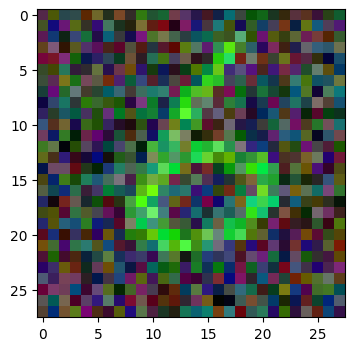

In [10]:
print(y,c)
plt.figure(figsize=(4,4))
plt.imshow(x[0])
plt.show()

## Create a model

We shall classify the digit as well as predominant colour (R,G,B)

Build the CNN with a customised architecture

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Add
from tensorflow.keras.models import Model

# Input layer gets the image (28,28,3)
input_ = Input(shape=(28, 28, 3), name='input')

# Layer 1
conv_1 = Conv2D(32, 3, name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)
pool_1 = MaxPool2D(4, name='pool_1')(act_1)
flat_1 = Flatten(name='flat_1')(pool_1)

# Color prediction branch
color = Dense(3, activation='softmax', name='color')(flat_1)

# Layer 2
conv_2 = Conv2D(32, 3, padding='same', name='conv_2')(act_1)
act_2 = Activation('relu', name='act_2')(conv_2)

# Layer 3 with skipped connection
conv_3 = Conv2D(32, 3, padding='same', name='conv_3')(act_2)
add = Add(name='add')([act_1, conv_3])  # Skip connection (residual)
act_3 = Activation('softmax', name='act_3')(add)
pool_2 = MaxPool2D(4, name='pool_2')(act_3)
flat_2 = Flatten(name='flat_2')(pool_2)

# Digit prediction branch
digit = Dense(10, activation='softmax', name='digit')(flat_2)

# Define the model with inputs and outputs
model = Model(input_, [digit, color])

# Compile the model with Sparse Categorical Crossentropy loss for each output
model.compile(loss={'digit': 'sparse_categorical_crossentropy', 'color': 'sparse_categorical_crossentropy'},
              optimizer='adam',
              metrics={'digit': 'accuracy', 'color': 'accuracy'})


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 26, 26, 32)           896       ['input[0][0]']               
                                                                                                  
 act_1 (Activation)          (None, 26, 26, 32)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 26, 26, 32)           9248      ['act_1[0][0]']               
                                                                                              

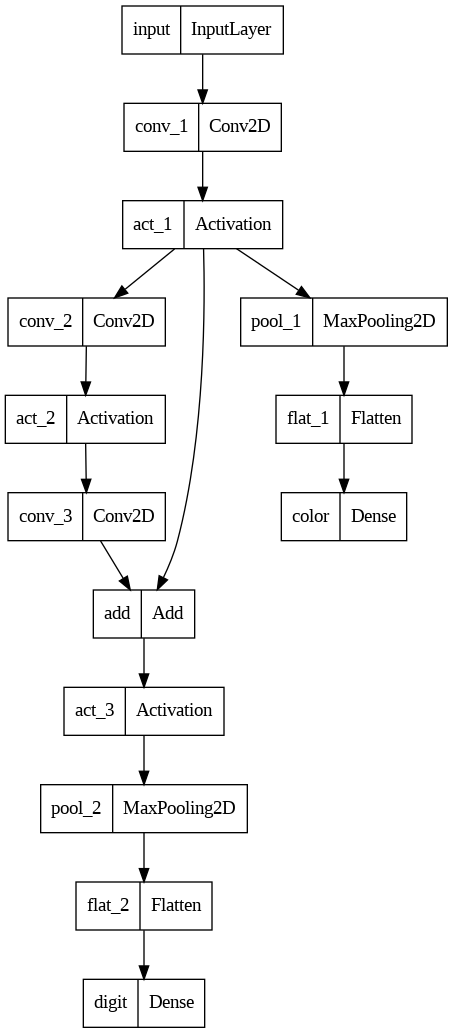

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model)

## Train the Model

In [16]:
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        digit_acc = logs.get('digit_accuracy')
        color_acc = logs.get('color_accuracy')
        val_dig_acc = logs.get('val_digit_accuracy')
        val_col_acc = logs.get('val_color_accuracy')

        print('=' * 30, f'Epoch {epoch + 1}', '=' * 30)
        print(f'Digit Accuracy: {digit_acc:.4f}')
        print(f'Color Accuracy: {color_acc:.4f}')
        print(f'Validation Digit Accuracy: {val_dig_acc:.4f}')
        print(f'Validation Color Accuracy: {val_col_acc:.4f}')

In [17]:
train_gen = generate_data(x_train, y_train, batch_size=32)
test_gen = generate_data(x_test, y_test, batch_size=32)  # Assuming you have validation data x_val and y_val



In [18]:
x,[y,c] = next(test_gen)

print(y,c)

[7. 2. 8. 8. 5. 7. 1. 5. 5. 6. 4. 2. 7. 4. 1. 7. 6. 2. 7. 4. 6. 0. 7. 6.
 3. 9. 7. 3. 1. 7. 4. 1.] [0. 2. 2. 1. 2. 0. 0. 0. 2. 2. 0. 2. 2. 1. 0. 2. 2. 1. 1. 2. 2. 1. 1. 0.
 0. 0. 0. 2. 1. 0. 2. 1.]


In [19]:
_ = model.fit(train_gen, steps_per_epoch=200, epochs=10,
          validation_data=test_gen, validation_steps=100,
             callbacks = [Logger()], verbose= False
             )

============================== Epoch 1 ==============================
Digit Accuracy: 0.3344
Color Accuracy: 0.9583
Validation Digit Accuracy: 0.8206
Validation Color Accuracy: 1.0000
============================== Epoch 2 ==============================
Digit Accuracy: 0.8763
Color Accuracy: 1.0000
Validation Digit Accuracy: 0.9125
Validation Color Accuracy: 1.0000
============================== Epoch 3 ==============================
Digit Accuracy: 0.9116
Color Accuracy: 1.0000
Validation Digit Accuracy: 0.9306
Validation Color Accuracy: 1.0000
============================== Epoch 4 ==============================
Digit Accuracy: 0.9291
Color Accuracy: 1.0000
Validation Digit Accuracy: 0.9319
Validation Color Accuracy: 1.0000
============================== Epoch 5 ==============================
Digit Accuracy: 0.9328
Color Accuracy: 1.0000
Validation Digit Accuracy: 0.9475
Validation Color Accuracy: 1.0000
============================== Epoch 6 ==============================
Digit Accu

## Predict the digit and color for test data

In [23]:
def test_model(show = True):

  x,[y,c] = next(test)

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = col_dict[np.argmax(preds[1])]
  gt_digit = int(y[0])
  gt_color = col_dict[int(c[0])]

  plt.imshow(x[0])
  if show:
    print(f'Actual: digit:{gt_digit}, color = {gt_color}')
    print(f'Predicted: digit:{pred_digit}, color = {pred_color}')


#test = generate_data(x_test, y_test, 1)

1/1 [==============================] - 0s 17ms/step
Actual: digit:5, color = green
Predicted: digit:5, color = green


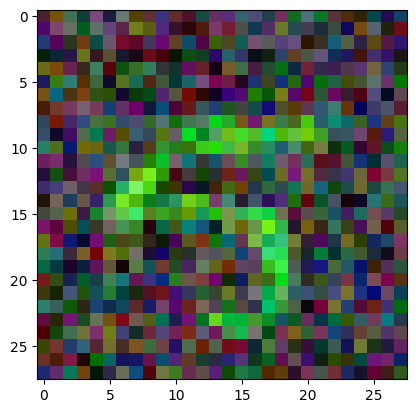

In [33]:
test_model()